**Assumptions:**

1.  Stock universe: S & P 100
2.  Time window: 10 years
3.  Trade Size: 1 share
4.  Transaction cost: 1%-1.5% of round trip trade's notional *(from paper)*
5.  Training Period: 2013-01-01 to 2022-12-31
6.  Testing Period: 2022-01-01 to 2023-12-31
7.  Ranking & Holding Period: In # of Months





**Task Allocations**


*   Gary - Data Processing and Methodology
*   Eric - Backtesting
*   Mark - Metrics Development & Evaluations





In [ ]:
# !pip install pandas openpyxl
# %pip install mplfinance

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from google.colab import files
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Processing & Signal Construction

In [2]:
# Read and print the stock tickers that make up S&P100
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/S%26P_100')[2]
print(tickers.head())
# Get the data for these tickers from yahoo finance
df = yf.download(tickers.Symbol.to_list(),'2012-12-31','2023-12-31')['Adj Close']
oex = yf.download('^OEX','2012-12-31','2023-12-31')['Adj Close']
# Dropping column BRK.B (class B share) as suggested in the paper
df = pd.concat([df,oex.rename('OEX')],axis=1)
df = df.drop(columns='BRK.B')
df.head()

  Symbol                 Name                  Sector
0   AAPL                Apple  Information Technology
1   ABBV               AbbVie             Health Care
2    ABT  Abbott Laboratories             Health Care
3    ACN            Accenture  Information Technology
4   ADBE                Adobe  Information Technology


[*********************100%%**********************]  101 of 101 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,OEX
Date,,,,,,,,,,,,,,,,,,,,,
2012-12-31,16.233,NaN,25.248,54.118,37.680,27.773,2.400,63.816,61.061,12.543,...,45.640,49.224,52.142,22.398,34.997,24.760,24.703,17.881,54.294,646.610
2013-01-02,16.748,22.002,25.748,56.201,38.340,28.701,2.530,66.000,62.468,12.866,...,45.893,50.297,53.967,23.120,35.875,25.333,25.332,18.145,55.649,663.870
2013-01-03,16.536,21.820,26.728,55.998,37.750,28.465,2.490,65.585,60.943,12.924,...,43.747,50.367,54.016,22.797,35.902,25.213,25.122,18.030,55.548,662.330
2013-01-04,16.076,21.545,26.568,56.307,38.130,28.560,2.590,65.874,60.887,12.958,...,43.831,51.248,54.150,23.295,36.195,25.350,25.252,18.098,55.805,664.690
2013-01-07,15.981,21.589,26.785,56.063,37.940,28.269,2.670,65.541,60.816,13.423,...,43.831,51.006,53.995,23.085,36.454,25.573,25.130,17.925,55.159,663.090


[*********************100%%**********************]  101 of 101 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  1 of 1 completed


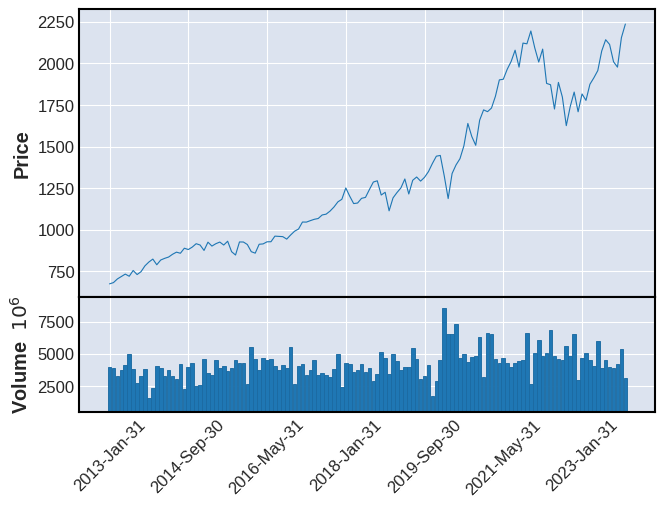

In [5]:
df_full = yf.download(tickers.Symbol.to_list(),'2013-01-01','2023-12-31')
oex_full = yf.download('^OEX','2013-01-01','2023-12-31')
import mplfinance as mpf
### Rolling one-month return for S&P100 index
resample = oex_full.resample('M').last()
mpf.plot(resample, type='line', volume=True)

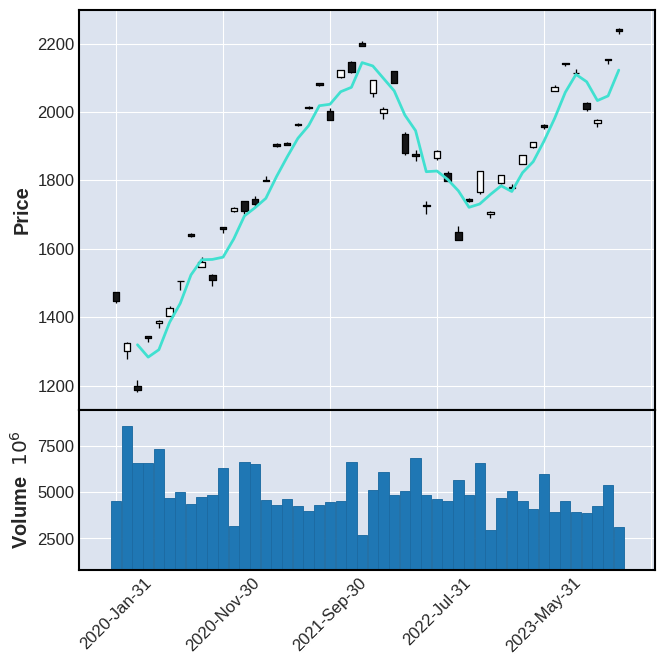

In [7]:
### Now we try to observe shorter period - Past 4 years from 2010-2013
resample = oex_full.resample('M').last()
#resample
#mpf.make_marketcolors(up="g", down="r")
mpf.plot(resample[-12*4:], type='candle',volume=True,figsize=(8,8),mav=3)

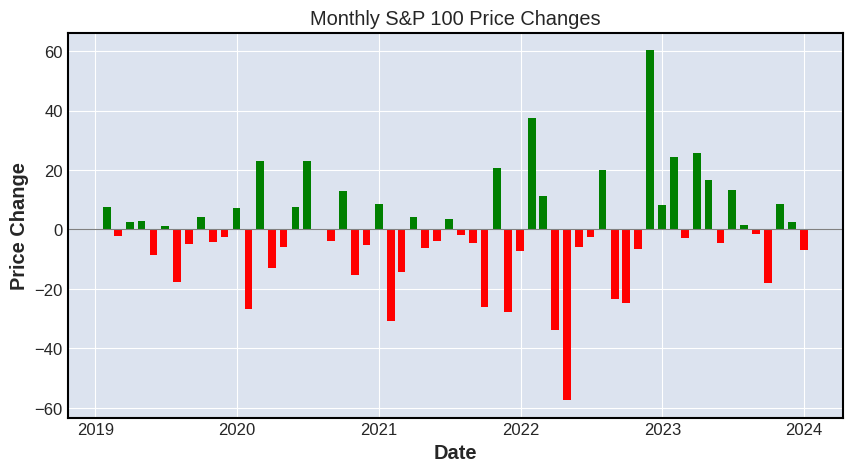

In [8]:
### Price change for S&P100 in recent years
oex_price_change = oex_full['Adj Close']  - oex_full['Open']
oex_resample = oex_price_change.resample('M').last()[-12*5:]
plt.figure(figsize=(10, 5))
colors = ['green' if x >= 0 else 'red' for x in oex_resample]
plt.bar(oex_resample.index, oex_resample,width=20,color=colors)
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Monthly S&P 100 Price Changes')
plt.axhline(0, color='grey', linewidth=0.8)
plt.show()

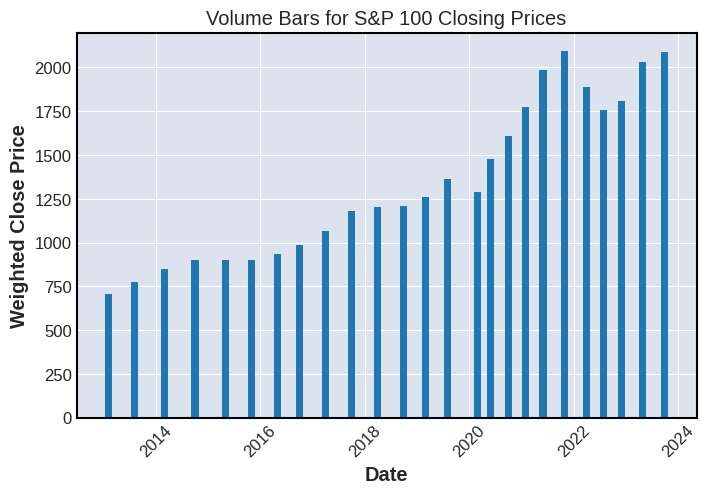

In [11]:
# Volume bar
volume_threshold = 25000000000

oex_volume_df = oex_full['Volume'].resample('M').last()
oex_price_df = oex_full['Adj Close'].resample('M').last()
df = oex_volume_df.to_frame().join(oex_price_df)

# Initialize variables
accumulated_volume = 0
accumulated_close = 0
volume_bars = {'Date': [], 'Volume Bar Close': [], 'Accumulated Volume': []}
current_start_date = df.index[0]
for date, row in df.iterrows():
    if accumulated_volume + row['Volume'] < volume_threshold:
        # Accumulate volume and adjust weighted close
        accumulated_volume += row['Volume']
        accumulated_close += row['Adj Close'] * row['Volume']
    else:
        # Finalize the current bar
        weighted_close = accumulated_close / accumulated_volume
        volume_bars['Date'].append(current_start_date)
        volume_bars['Volume Bar Close'].append(weighted_close)
        volume_bars['Accumulated Volume'].append(accumulated_volume)
        # Start new bar
        accumulated_volume = row['Volume']
        accumulated_close = row['Adj Close'] * row['Volume']
        current_start_date = date
# Add the last bar if any volume is left
if accumulated_volume > 0:
    weighted_close = accumulated_close / accumulated_volume
    volume_bars['Date'].append(current_start_date)
    volume_bars['Volume Bar Close'].append(weighted_close)
    volume_bars['Accumulated Volume'].append(accumulated_volume)
volume_bars_df = pd.DataFrame(volume_bars)
volume_bars_df['Date'] = pd.to_datetime(volume_bars_df['Date'])
# Plot
plt.figure(figsize=(8, 5))
plt.bar(volume_bars_df['Date'], volume_bars_df['Volume Bar Close'], width=50)
plt.xlabel('Date')
plt.ylabel('Weighted Close Price')
plt.title('Volume Bars for S&P 100 Closing Prices')
plt.xticks(rotation=45)
plt.show()

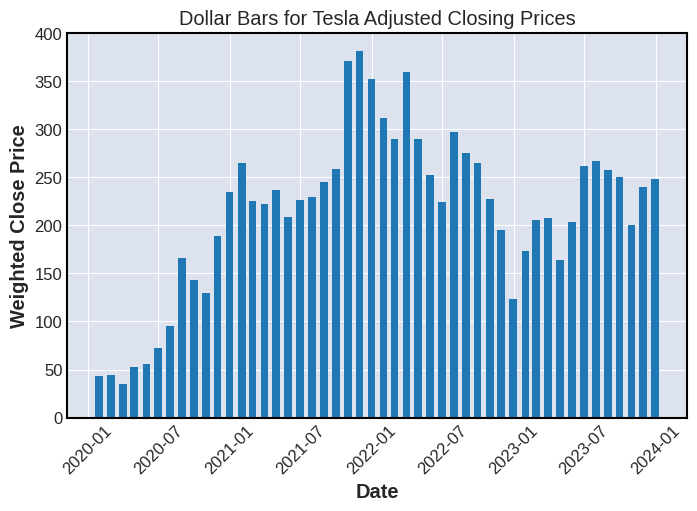

In [12]:
### Dollar bar
# Define dollar threshold per bar
dollar_threshold = 200000  # Example threshold
tesla_volume_df = df_full['Volume'].resample('M').last()['TSLA'].iloc[-12*4:]
tesla_price_df = df_full['Adj Close'].resample('M').last()['TSLA'].iloc[-12*4:]
df_dollar = tesla_volume_df.to_frame(name='Volume').join(tesla_price_df)
df_dollar = df_dollar.rename(columns={'TSLA': 'Adj Close'})

# Initialize variables
accumulated_dollars = 0
accumulated_value = 0
accumulated_volume = 0
dollar_bars = {'Date': [], 'Dollar Bar Close': [], 'Accumulated Dollars': []}
current_start_date = df_dollar.index[0]
for date, row in df_dollar.iterrows():
    current_dollars = row['Adj Close'] * row['Volume']
    if accumulated_dollars + current_dollars < dollar_threshold:
        accumulated_dollars += current_dollars
        accumulated_value += row['Adj Close'] * row['Volume']
        accumulated_volume += row['Volume']
    else:
        # Calculate weighted close using accumulated values
        weighted_close = accumulated_value / accumulated_volume if accumulated_volume > 0 else row['Adj Close']
        dollar_bars['Date'].append(current_start_date)
        dollar_bars['Dollar Bar Close'].append(weighted_close)
        dollar_bars['Accumulated Dollars'].append(accumulated_dollars)
        # Reset for next bar
        accumulated_dollars = current_dollars
        accumulated_value = row['Adj Close'] * row['Volume']
        accumulated_volume = row['Volume']
        current_start_date = date
# Add the last bar if any dollar amount is left
if accumulated_dollars > 0:
    weighted_close = accumulated_value / accumulated_volume
    dollar_bars['Date'].append(current_start_date)
    dollar_bars['Dollar Bar Close'].append(weighted_close)
    dollar_bars['Accumulated Dollars'].append(accumulated_dollars)
dollar_bars_df = pd.DataFrame(dollar_bars)
dollar_bars_df['Date'] = pd.to_datetime(dollar_bars_df['Date'])
# Plot
plt.figure(figsize=(8, 5))
plt.bar(dollar_bars_df['Date'], dollar_bars_df['Dollar Bar Close'], width=20)
plt.xlabel('Date')
plt.ylabel('Weighted Close Price')
plt.title('Dollar Bars for Tesla Adjusted Closing Prices')
plt.xticks(rotation=45)
plt.show()

In [ ]:
### Define required functions
# Function to compute returns based on the number of months of ranking period, assuming standard 21 trading days per month
def get_return(df,n_months):
  return df.pct_change(periods=n_months*21)

# Function to identify the top n stocks to pick from, returning 1 as value for the top stocks, 0 otherwise
def get_top_n(ret_df, n):
    ls=[]
    for index, row in ret_df.iterrows():
        k=[]
        largest = row.nlargest(n).values
        for i in row:
            if i in largest:
                k.append(1)
            else:
                k.append(0)
        ls.append(k)
    return pd.DataFrame(ls,ret_df.index,ret_df.columns)

In [ ]:
### Signal construction - 1. From the daily adj close dataset, calculate returns depending on the n_month ranking window parameter
###                       2. Generate the dataframe showing the top n winners and losers (default 10 as we are using S&P100)
###                       3. Generate the 'signals' dataframe showing the trading signals, 1 means long, -1 means short
###                       4. For example, Long AMD on '2023-12-27' as the rolling 1-month return as of that date is amongst the top 10 stocks,
###                          short UNH on '2023-12-22' as the rolling 1-month return of UNH as of that date is amongst the worst 10 stocks

def generate_signal(df, n_month, n=10):
  df = df.iloc[:,:-1]
  signals = pd.DataFrame(index=df.index, columns=df.columns)
  ret_df = get_return(df, n_month)
  winner = get_top_n(ret_df, n)
  loser = get_top_n(-ret_df, n)
  signals = pd.DataFrame(0, index=df.index, columns=df.columns)
  signals[winner == 1] = 1  # Set +1 for top performers
  signals[loser == 1] = -1  # Set -1 for bottom performers
  return winner, loser, signals

# Backtesting

In [ ]:
def compute_winners_losers_pnls(df_pnl):
  """
  Function to break down the total realized pnl into winners and losers pnls.
  Helper function for strategy_backtesting

  Parameters
  ----------
  df_pnl: pd.DataFrame
      a dataframe containing the daily pnl of the portfolio separated by stocks

  Returns
  -------
  winners: pd.Series
      a time-series record of the PnLs of all the winners (i.e,
      stocks that are in the top n_stocks of returns rankings)
  losers: pd.Series
      a time-series record of the PnLs of all the losers (i.e,
      stocks that are in the bottom n_stocks of returns rankings)


  Example
  --------
  >>> winners_pnl,losers_pnl = compute_winners_losers_pnls(df_pnl)
  """
  winners = pd.DataFrame(0,index=df_pnl.index,columns=['PnL'])
  losers = pd.DataFrame(0,index=df_pnl.index,columns=['PnL'])
  assert(len(df_pnl)%2 == 0)
  for i in range(0,len(df_pnl),2):
    row = df_pnl.iloc[i]
    next_row = df_pnl.iloc[i + 1]
    winner_pnl = row[row < 0].sum()
    winner_cols = row[row < 0].index
    winner_next_pnl = next_row[winner_cols].sum()
    loser_pnl = row[row > 0].sum()
    loser_cols = row[row > 0].index
    loser_next_pnl = next_row[loser_cols].sum()
    winners.iloc[i] = winner_pnl
    winners.iloc[i+1] = winner_next_pnl
    losers.iloc[i] = loser_pnl
    losers.iloc[i+1] = loser_next_pnl

  winners = winners['PnL']
  losers = losers['PnL']
  return winners,losers


def strategy_backtesting(df,ranking_period,holding_period,\
                         slippage=15,mode='train',n_stock=10):
  """
  Function to back test momentum strategy based on given stock-level data,
  ranking & holding periods. The function can take 2 modes: train and test, and
  it assumes the aforementioned training & testing periods.

  Parameters
  ----------
  df : pd.DataFrame
      Stock-level dataframe generated
  ranking_period : int
      length of ranking period in number of months
  holding_period : int
      length of holding period in number of months (in general, holding_period
      should be less than or equal to ranking_period)
  slippage: float
      per-order negative trading slippage induced by market friction,
      expressed as bps of the order's notional, default is 15 bps
  mode: str
      train or test, default is 'train'
  n_stock: int
      top/bottom (n_stock) stocks to be included in long/short positions,
      default is 10

  Returns
  -------
  winners_pnl: pd.Series
      a time-series record of the PnLs of all the winners (i.e,
      stocks that are in the top n_stocks of returns rankings)
  losers_pnl: pd.Series
      a time-series record of the PnLs of all the losers (i.e,
      stocks that are in the bottom n_stocks of returns rankings)
  total_pnl: pd.Series
      a time-series record of the total PnLs of the portfolio
      (note: winners_pnl + losers_pnl = total_pnl)

  Example
  --------
  >>> winners_pnl,losers_pnl,total_pnl = strategy_backtesting(df,4,2)
  """
  cutoff='2022-01-01'
  holding_period = holding_period * 21
  winner, loser, pos = generate_signal(df, ranking_period, n_stock)
  if (mode == 'train'):
    pos = pos[pos.index<pd.to_datetime(cutoff)]
    portfolio = pos.iloc[::holding_period].iloc[1:]
  else:
    pos = pos[pos.index>=pd.to_datetime(cutoff)]
    portfolio = pos.iloc[::holding_period].iloc[1:]
  length = len(portfolio)
  rebalancing_idx = np.arange(holding_period,\
                              (length+1)*holding_period,holding_period) - 1
  rebalancing_dates = pos.index[rebalancing_idx]
  last_rebalancing_date = pd.DatetimeIndex([pos.index[-1]])
  rebalancing_dates = rebalancing_dates.append(last_rebalancing_date)[1:]
  rebalancing_df = (-1*portfolio)
  rebalancing_df.set_index(rebalancing_dates,inplace=True)

  df_portfolio = pd.concat([portfolio, rebalancing_df])
  df_portfolio.sort_index(inplace=True)
  df_portfolio.iloc[-1] = -1 * df_portfolio.iloc[-2]

  df_prices = df.loc[df_portfolio.index]
  df_pnl = df_portfolio * df_prices * -1

  df_pnl = df_pnl.applymap(lambda x:x*(1+slippage/10000) if x<0 \
                                   else x*(1-slippage/10000))

  winners_pnl,losers_pnl = compute_winners_losers_pnls(df_pnl)
  total_pnl = df_pnl.sum(axis=1)
  assert int(sum(winners_pnl)+sum(losers_pnl)) == int(sum(total_pnl))
  return winners_pnl,losers_pnl,total_pnl

def plot_pnl_breakdown(winners_pnl,losers_pnl,total_pnl,R,H):
  """
  Function to plot the pnl breakdowns (i.e, winners, losers, and total pnl)

  Parameters
  ----------
  winners_pnl : pd.Series
      time-series winners pnl
  losers_pnl : pd.Series
      time-series losers pnl
  total_pnl : pd.Series
      time-series total pnl
  R: int
      length of ranking period
  H: int
      length of holding period

  Returns
  -------
  None

  Example
  --------
  >>> plot_pnl_breakdown(winners_pnl,losers_pnl,total_pnl,4,2)
  """
  def dollar_formatter(x, pos):
    if x < 0:
        return f'-${-x:.0f}'
    else:
        return f'${x:.0f}'
  total_pnl = total_pnl.cumsum()
  winners_pnl = winners_pnl.cumsum()
  losers_pnl = losers_pnl.cumsum()
  final_total_pnl = int(total_pnl[-1])
  final_winners_pnl = int(winners_pnl[-1])
  final_losers_pnl = int(losers_pnl[-1])

  fig,ax = plt.subplots(figsize=(9,4))
  total_pnl_label = f'Final PnL:$'+str(final_total_pnl) if final_total_pnl>=0 \
                    else f'Final PnL:-$'+str(abs(final_total_pnl))
  winners_pnl_label = f'Winners PnL:$'+str(final_winners_pnl) if final_winners_pnl>=0 \
                    else f'Winners PnL:-$'+str(abs(final_winners_pnl))
  losers_pnl_label = f'Losers PnL:$'+str(final_losers_pnl) if final_losers_pnl>=0 \
                    else f'Losers PnL:-$'+str(abs(final_losers_pnl))
  sns.lineplot(x=winners_pnl.index,y=winners_pnl.values,\
           label=winners_pnl_label)
  sns.lineplot(x=losers_pnl.index,y=losers_pnl.values,\
           label=losers_pnl_label)
  sns.lineplot(x=total_pnl.index,y=total_pnl.values,\
           label=total_pnl_label)
  plt.xlabel('Year')
  plt.ylabel('PnL')
  formatter = FuncFormatter(dollar_formatter)
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.title(f'Realized PnL Breakdown with R={R},H={H}')
  sns.set_style('darkgrid')
  sns.set_context('notebook')
  plt.legend(prop={'size': 2.5})
  plt.tight_layout()
  plt.show()

def compute_returns_stats(pnls,H):
  """
  Function to compute annual returns and stdev

  Parameters
  ----------
  pnls : pd.Series
      time-series pnl
  H: int
      length of holding period

  Returns
  -------
  annual_return: float
      estimated annual returns of the strategy
  annual_std: float
      estimated annual returns standard deviation of the strategy

  Example
  --------
  >>> annual_return,annual_std = compute_returns_stats(pnls,h)
  """

  dates = pnls.index
  returns = pd.Series(index=dates)
  for i in range(0, len(pnls), 2):
    try:
      curr_pnl = pnls[dates[i]]
      next_pnl = pnls[dates[i+1]]
      if (int(curr_pnl)!=0):
        returns[dates[i]] = ((curr_pnl+next_pnl)/(abs(curr_pnl)))
    except:
      continue
  returns.dropna(inplace=True)
  annual_return = returns.resample('Y').mean()
  annual_std = returns.resample('Y').std().mean()
  return annual_return, annual_std


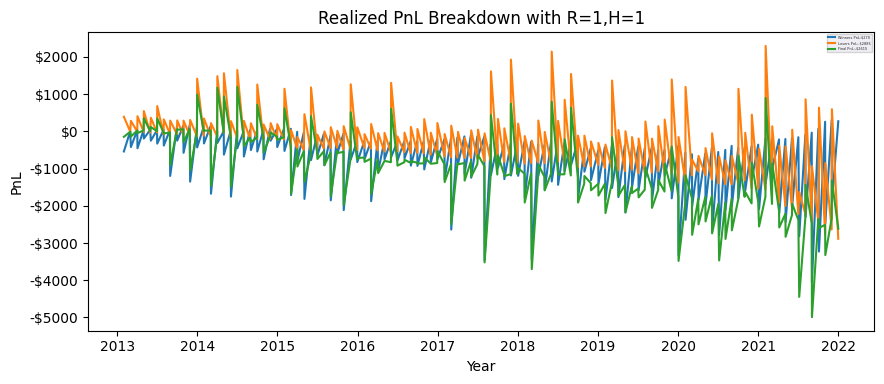

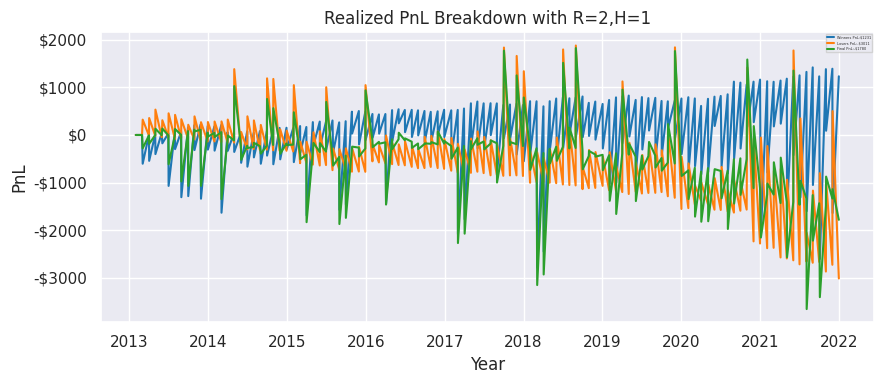

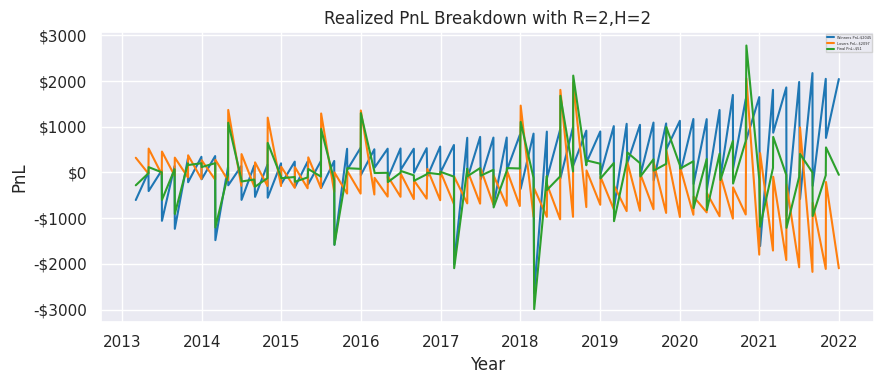

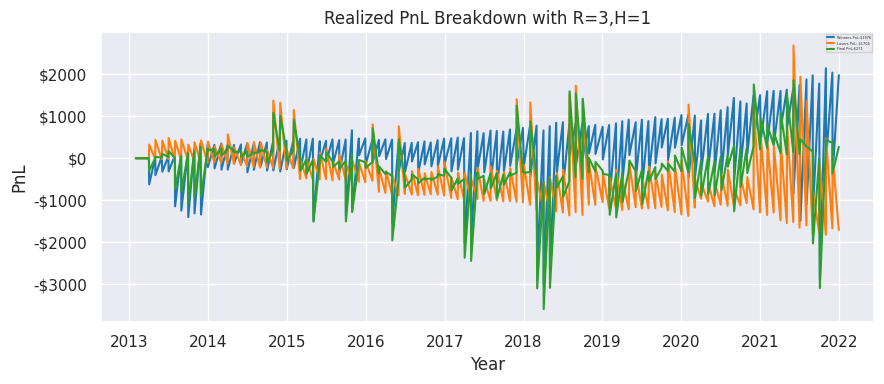

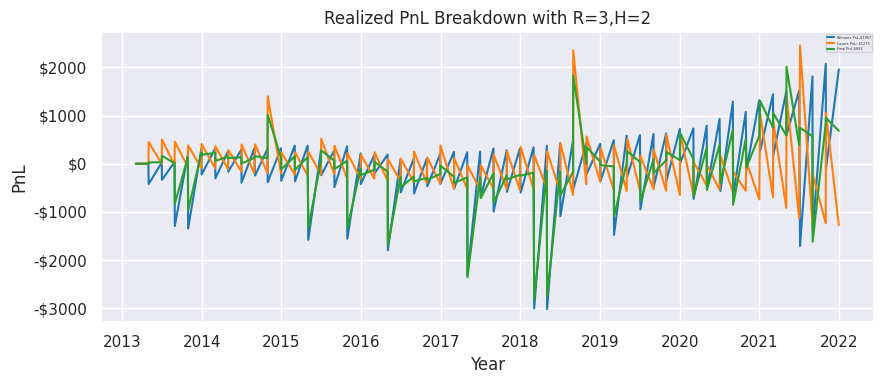

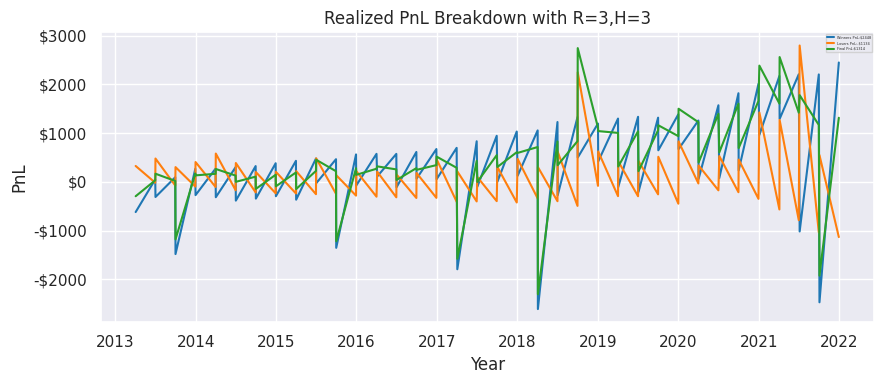

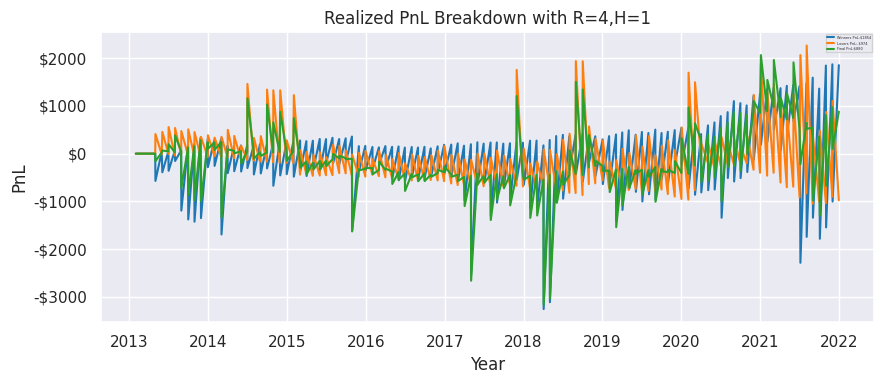

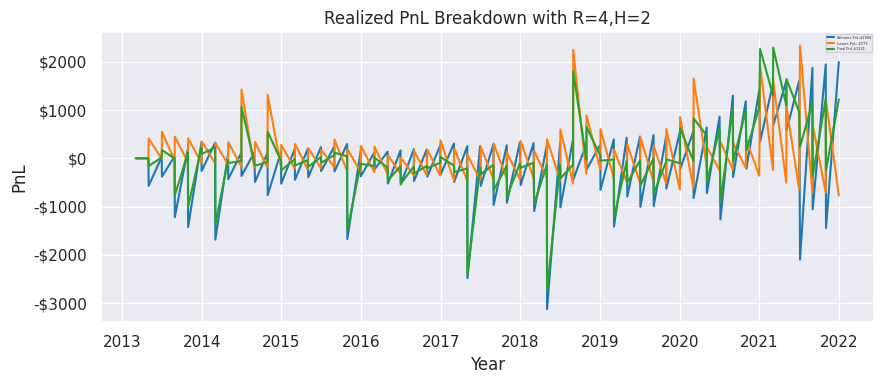

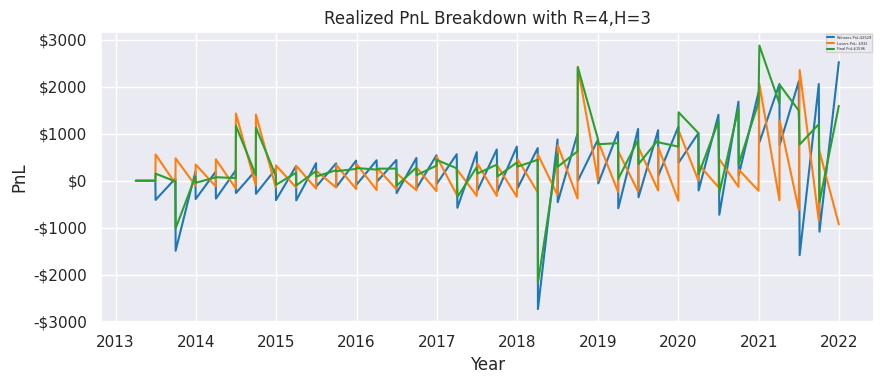

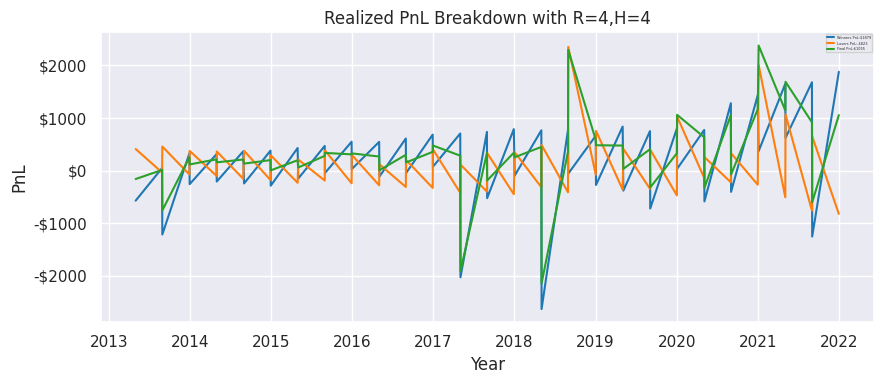

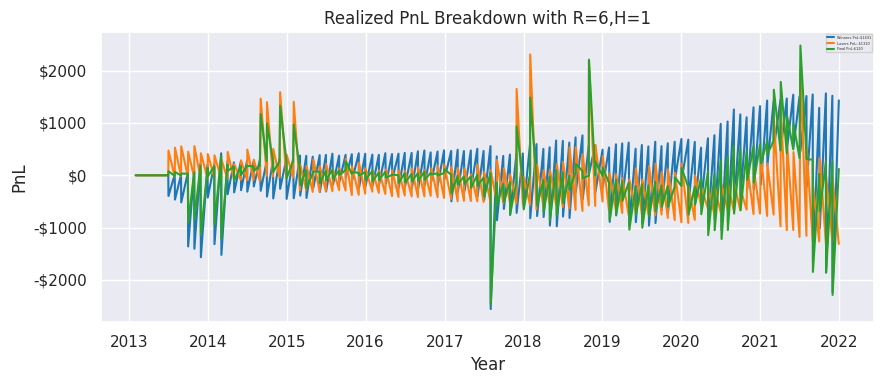

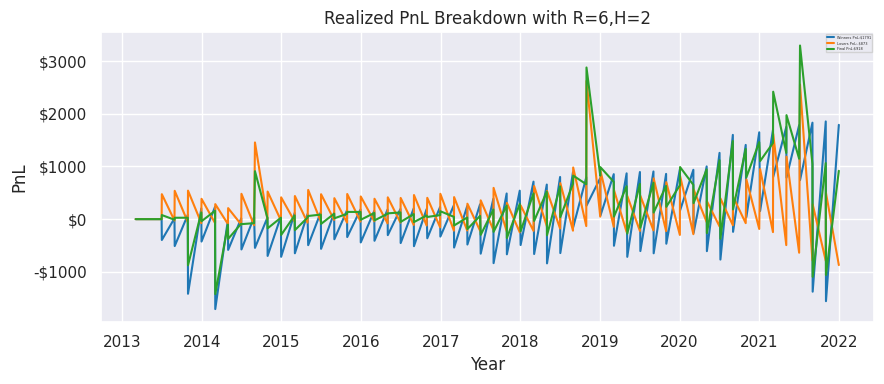

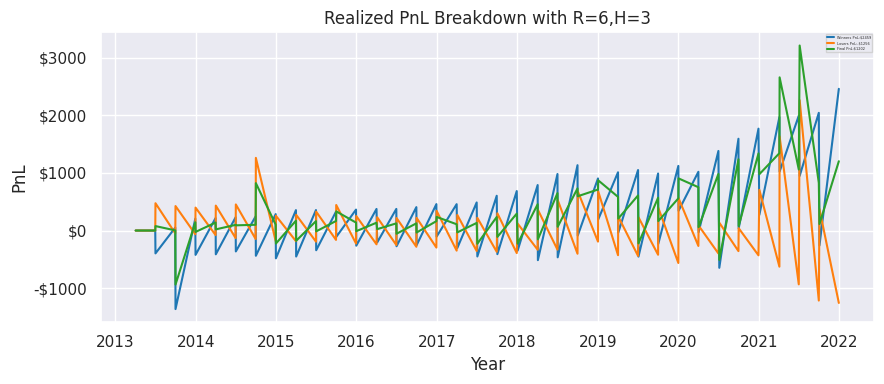

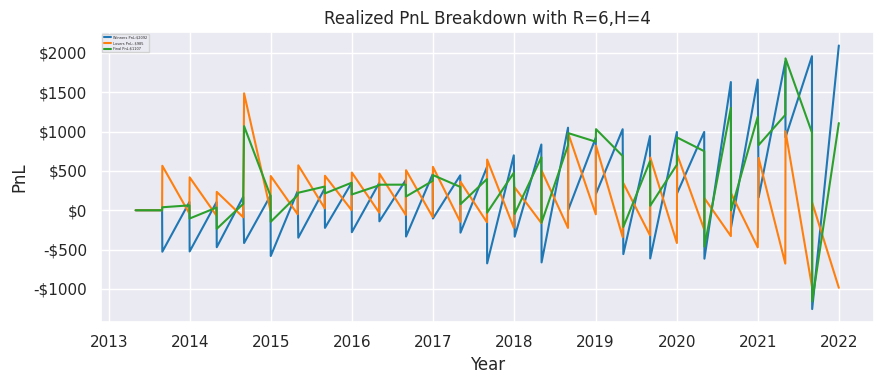

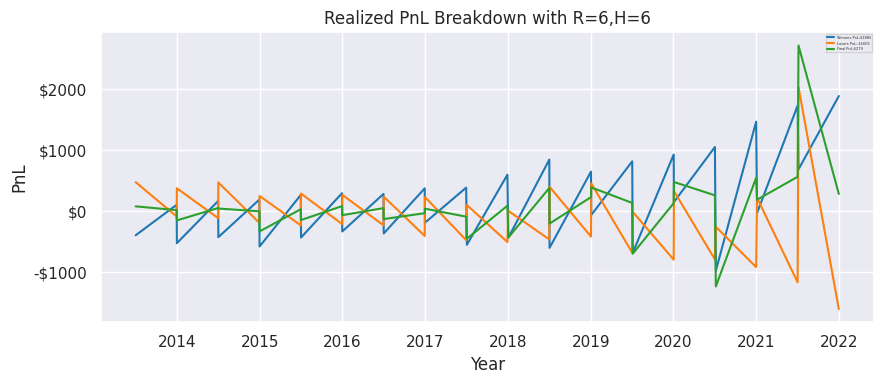

In [ ]:
# test code to generate some plots
Rs = [1,2,3,4,6]
Hs = [1,2,3,4,6]
def plotting_func(df, Rs, Hs, mode):
  total_pnls = []
  winners_pnls = []
  losers_pnls = []
  for i in range(len(Rs)):
    for q in range(i+1):
      R,H = Rs[i],Hs[q]
      winners_pnl,losers_pnl,total_pnl = strategy_backtesting(df,R,H,mode=mode)
      plot_pnl_breakdown(winners_pnl,losers_pnl,total_pnl,R,H)

plotting_func(df, Rs, Hs,mode="train")

# Performance Metrics

In [ ]:
def calculate_performance_metrics(df, risk_free_rate, Rs, Hs, mode='train'):
  metrics_dfs = {}
  for R in Rs:
    for H in Hs:
      if H>R:
        continue
      winners_pnl, losers_pnl, total_pnl = strategy_backtesting(df, R, H, mode=mode)

      # raw returns
      yearly_winners_returns, winners_volatility = compute_returns_stats(winners_pnl, H)
      yearly_losers_returns, losers_volatility = compute_returns_stats(losers_pnl, H)
      yearly_momentum_returns, momentum_volatility = compute_returns_stats(total_pnl, H)

      # excess returns
      yearly_benchmark_returns = df['OEX'].resample('Y').last().pct_change().dropna()
      if (mode == 'train'):
        yearly_benchmark_returns = yearly_benchmark_returns[:-2]
      else:
        yearly_benchmark_returns = yearly_benchmark_returns[-2:]

      winners_excess_return = yearly_winners_returns.mean()-yearly_benchmark_returns.mean()
      losers_excess_return = yearly_losers_returns.mean()-yearly_benchmark_returns.mean()
      momentum_excess_return = yearly_momentum_returns.mean()-yearly_benchmark_returns.mean()

      # systematic risk (beta)
      covariance = yearly_momentum_returns.cov(yearly_benchmark_returns)
      variance = yearly_benchmark_returns.var()
      beta = covariance / variance
      yearly_total_pnl = total_pnl.resample('Y').sum()

      drawdowns = (yearly_total_pnl - yearly_total_pnl.cummax()) / yearly_total_pnl.cummax()
      momentum_max_drawdown = drawdowns.min()


      #volatility calculations might yield nan at the start of data
      momentum_sharpe_ratio = (yearly_momentum_returns.mean()-risk_free_rate)/momentum_volatility if momentum_volatility != 0 else np.nan

      downside_returns = yearly_total_pnl[yearly_total_pnl<0]
      downside_volatility = downside_returns.std()
      momentum_sortino_ratio = (yearly_momentum_returns.mean()-risk_free_rate)/downside_volatility

      metrics = {
          'Winners PnL': winners_pnl.sum(),
          'Losers PnL': losers_pnl.sum(),
          'Total PnL': total_pnl.sum(),
          'Winners Raw Return': yearly_winners_returns.mean(),
          'Losers Raw Return': yearly_losers_returns.mean(),
          'Total Raw Return': yearly_momentum_returns.mean(),
          'Winners Excess Return': winners_excess_return,
          'Losers Excess Return': losers_excess_return,
          'Excess Return': momentum_excess_return,
          'Winners Volatility': winners_volatility,
          'Losers Volatility': losers_volatility,
          'Volatility': momentum_volatility,
          'Systematic Risk (beta)': beta,
          'Max Drawdown': momentum_max_drawdown,
          'Sharpe Ratio': momentum_sharpe_ratio,
          'Sortino Ratio': momentum_sortino_ratio
      }

      metrics_dfs[f'(R,H)=({R},{H})'] = metrics

  index_order = metrics.keys()
  return pd.DataFrame(metrics_dfs,index=index_order)


def get_annualized_sp500_return(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
    annual_return = sp500.resample('Y').last().pct_change().mean()
    return annual_return


In [ ]:
Rs = [1,2,3,4,6]
Hs = [1,2,3,4,6]
risk_free_rate = get_annualized_sp500_return('2012-12-31', '2023-12-31')
metrics_df = calculate_performance_metrics(df, risk_free_rate, Rs, Hs)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# download as excel for formatting
file_name = '/content/metrics.xlsx'
metrics_df.to_excel(file_name, engine='openpyxl')

In [ ]:
# Optimization for looking at different "best performing" metrics
# highest total pnl
highest_profitability = metrics_df.loc['Total PnL'].idxmax()
highest_profitability_value = metrics_df.loc['Total PnL', highest_profitability]

# Highest Sharpe Ratio
best_risk_adjusted_return = metrics_df.loc['Sharpe Ratio'].idxmax()
best_risk_adjusted_return_value = metrics_df.loc['Sharpe Ratio', best_risk_adjusted_return]

# lowest Risk based on Volatility
lowest_volatility = metrics_df.loc['Volatility'].idxmin()
lowest_volatility_value = metrics_df.loc['Volatility', lowest_volatility]

# lowest Risk based on Maximum Drawdown
lowest_max_drawdown = metrics_df.loc['Max Drawdown'].idxmin()
lowest_max_drawdown_value = metrics_df.loc['Max Drawdown', lowest_max_drawdown]


print(f"Highest Profitability (R, H): {highest_profitability} with Total PnL: {highest_profitability_value}")
print(f"Best Risk-Adjusted Return (R, H): {best_risk_adjusted_return} with Sharpe Ratio: {best_risk_adjusted_return_value}")
print(f"Lowest Risk by Volatility (R, H): {lowest_volatility} with Volatility: {lowest_volatility_value}")
print(f"Lowest Risk by Maximum Drawdown (R, H): {lowest_max_drawdown} with Max Drawdown: {lowest_max_drawdown_value}")

Highest Profitability (R, H): (R,H)=(4,3) with Total PnL: 1596.686709766509
Best Risk-Adjusted Return (R, H): (R,H)=(6,4) with Sharpe Ratio: 0.25587538762100837
Lowest Risk by Volatility (R, H): (R,H)=(6,3) with Volatility: 0.22819304455684725
Lowest Risk by Maximum Drawdown (R, H): (R,H)=(4,2) with Max Drawdown: -4.786721301152753


In [ ]:
# Optimization

# first filter out candidates with positive total raw returns
positive_raw_returns = metrics_df.loc['Total Raw Return'] > 0
candidates_positive_raw = metrics_df.loc[:, positive_raw_returns]

# then from previous subset filter out candidates with positive excess returns
positive_excess_returns = candidates_positive_raw.loc['Excess Return'] > 0
candidates_positive_excess = candidates_positive_raw.loc[:, positive_excess_returns]

# finally from previous subset filter out candidate with highest sharpe ratio
highest_sharpe_ratio = candidates_positive_excess.loc['Sharpe Ratio'].idxmax()
highest_sharpe_ratio_value = candidates_positive_excess.loc['Sharpe Ratio', highest_sharpe_ratio]

# printing out candidate and respective performance metrics
print(f"The (R, H) combination with positive raw returns, \
positive excess returns, and the highest Sharpe Ratio is: {highest_sharpe_ratio} with a Sharpe Ratio of: {highest_sharpe_ratio_value}")
metrics_df[highest_sharpe_ratio]

The (R, H) combination with positive raw returns, positive excess returns, and the highest Sharpe Ratio is: (R,H)=(6,4) with a Sharpe Ratio of: 0.25587538762100837


Winners PnL              2092.681
Losers PnL               -985.220
Total PnL                1107.461
Winners Raw Return          0.082
Losers Raw Return          -0.059
Total Raw Return            0.293
Winners Excess Return      -0.069
Losers Excess Return       -0.211
Excess Return               0.141
Winners Volatility          0.097
Losers Volatility           0.102
Volatility                  0.649
Systematic Risk (beta)     -1.723
Max Drawdown               -2.829
Sharpe Ratio                0.256
Sortino Ratio               0.000
Name: (R,H)=(6,4), dtype: float64

                        (R,H)=(6,4)
Winners PnL                1252.962
Losers PnL                 -365.048
Total PnL                   887.915
Winners Raw Return            0.044
Losers Raw Return            -0.087
Total Raw Return              0.350
Winners Excess Return         0.001
Losers Excess Return         -0.130
Excess Return                 0.306
Winners Volatility            0.119
Losers Volatility             0.043
Volatility                    0.899
Systematic Risk (beta)       -2.076
Max Drawdown                  0.000
Sharpe Ratio                  0.248
Sortino Ratio                   NaN


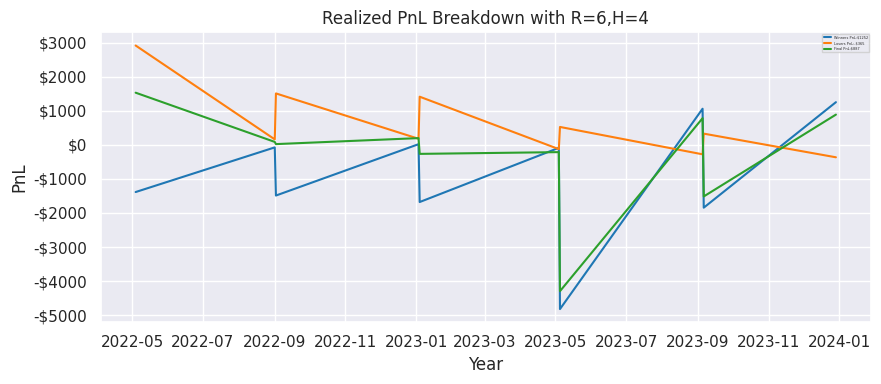

In [ ]:
# using previous optimal candidate to run on testing data to observe performance
best_R, best_H = [6], [4]
testing_metics_best = calculate_performance_metrics(df, risk_free_rate, best_R, best_H, mode="test")
print(testing_metics_best)

plotting_func(df, best_R, best_H, mode="test")